# Database — Report

Interactive visuals for the **Database** block using CSV files located at:
`reports/custom-queries-csv/Database/`

## What’s Included
- **Treemap + Top Tables Bar** replacing the hard-to-read Entity→Table Sankey.
- **Annotation Overview**: global Top Annotations + **stacked bars per entity** (clearer than a large heatmap).
- **Entity→Entity Sankey** kept **optional** if the edges CSV contains rows.
- **Relationship Statistics** from `DB_Schema.csv`: top entities by count and histogram distribution.


In [1]:
# Setup: imports, robust path resolver, helpers
import os, ast, glob
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('future.no_silent_downcasting', True)

# ---- Path resolution ----
def resolve_reports_dir():
    # 1) Honor environment variable if valid
    env = os.environ.get("REPORTS_DIRECTORY")
    if env:
        p = Path(env).expanduser().resolve()
        if p.exists():
            return str(p)
    # 2) Walk upwards to find a 'reports' folder
    cwd = Path.cwd()
    for i in range(0, 8):
        base = cwd if i == 0 else cwd.parents[i-1]
        cand = base / "reports"
        if cand.exists():
            return str(cand.resolve())
    # 3) Fallback relative to CWD
    return str((Path.cwd() / "reports").resolve())

REPORTS_DIR = resolve_reports_dir()
DB_DIR = os.path.join(REPORTS_DIR, "custom-queries-csv", "Database")

print("REPORTS_DIR =", REPORTS_DIR)
print("DB_DIR      =", DB_DIR)
print("DB_DIR exists? ->", os.path.exists(DB_DIR))
print("Files under DB_DIR:")
for p in sorted(glob.glob(os.path.join(DB_DIR, "*"))):
    print(" -", p)

# ---- CSV IO helpers ----
NA_LITS = ["", " ", "NA", "N/A", "n/a", "NaN", "NULL", "Null", "null", "None", "none", "-", "--"]

def read_csv_safe(p):
    if not os.path.exists(p):
        print(f"[info] Missing CSV: {p}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(p, na_values=NA_LITS, keep_default_na=True)
        df.columns = [str(c).strip() for c in df.columns]
        df = df.dropna(how="all")  # drop completely empty rows if any
        return df
    except Exception as e:
        print(f"[warn] Failed to read {p}: {e}")
        return pd.DataFrame()

def labelize_na(s, label="N/A"):
    s = s.copy()
    s = s.mask(s.isna(), label).astype(str)
    s = s.replace({"nan": label, "NaN": label})
    return s

def entity_package(fqn: str) -> str:
    s = str(fqn or "")
    if "." in s:
        return ".".join(s.split(".")[:-1])
    return "(default)"

def parse_listlike(x):
    """Return a list from cell x tolerant to JSON/Python lists or common separators."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, (list, tuple, set)):
        return [str(i).strip() for i in x if str(i).strip()]
    s = str(x).strip()
    if not s or s in {"N/A","NA","null","None"}:
        return []
    if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple, set)):
                return [str(i).strip() for i in val if str(i).strip()]
        except Exception:
            pass
    for sep in [";", ",", "|"]:
        if sep in s:
            return [t.strip() for t in s.split(sep) if t.strip()]
    return [s]

def find_col(df, *cands, default=None, contains=None):
    """Find a column by exact candidates or by substring (contains)."""
    low = {c.lower(): c for c in df.columns}
    for c in cands:
        if c and c.lower() in low:
            return low[c.lower()]
    if contains:
        for k, orig in low.items():
            if contains.lower() in k:
                return orig
    return default

TOP_N = 40
MAX_BARS = 25  # cap for long bar charts


REPORTS_DIR = /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports
DB_DIR      = /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/custom-queries-csv/Database
DB_DIR exists? -> True
Files under DB_DIR:
 - /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/custom-queries-csv/Database/DB_Schema.csv
 - /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/custom-queries-csv/Database/Entity_Fields.csv
 - /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/custom-queries-csv/Database/Entity_Relationship_Edges.csv
 - /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/custom-queries-csv/Database/Jpa_Entities.csv


## 1) Entities mapped to Tables — Treemap + Top Tables

,Entity,TableName,HasInheritance,Source Cypher File: Custom_Queries/Database/Jpa_Entities.cypher
0,com.salesmanager.core.model.catalog.catalog.Ca...,Catalog,True,NaN
1,com.salesmanager.core.model.catalog.catalog.Ca...,Catalog,True,NaN
2,com.salesmanager.core.model.catalog.catalog.Ca...,CatalogCategoryEntry,True,NaN
3,com.salesmanager.core.model.catalog.catalog.Ca...,CatalogCategoryEntry,True,NaN
4,com.salesmanager.core.model.catalog.category.C...,Category,True,NaN
5,com.salesmanager.core.model.catalog.category.C...,Category,True,NaN
6,com.salesmanager.core.model.catalog.category.C...,CategoryDescription,True,NaN
7,com.salesmanager.core.model.catalog.category.C...,CategoryDescription,True,NaN
8,com.salesmanager.core.model.catalog.product.Pr...,Product,True,NaN
9,com.salesmanager.core.model.catalog.product.Pr...,Product,True,NaN


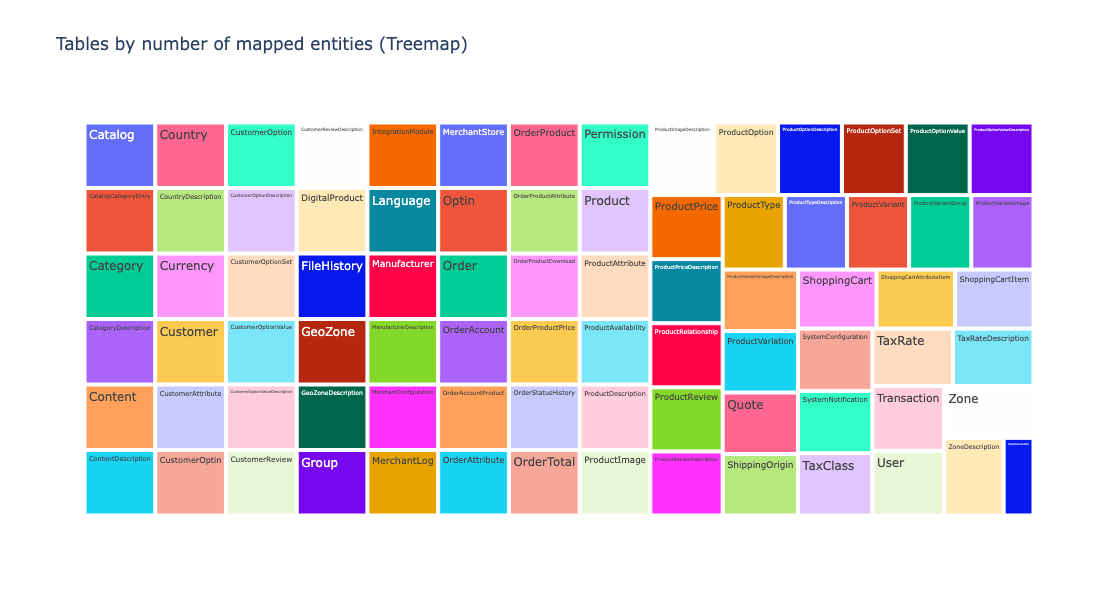

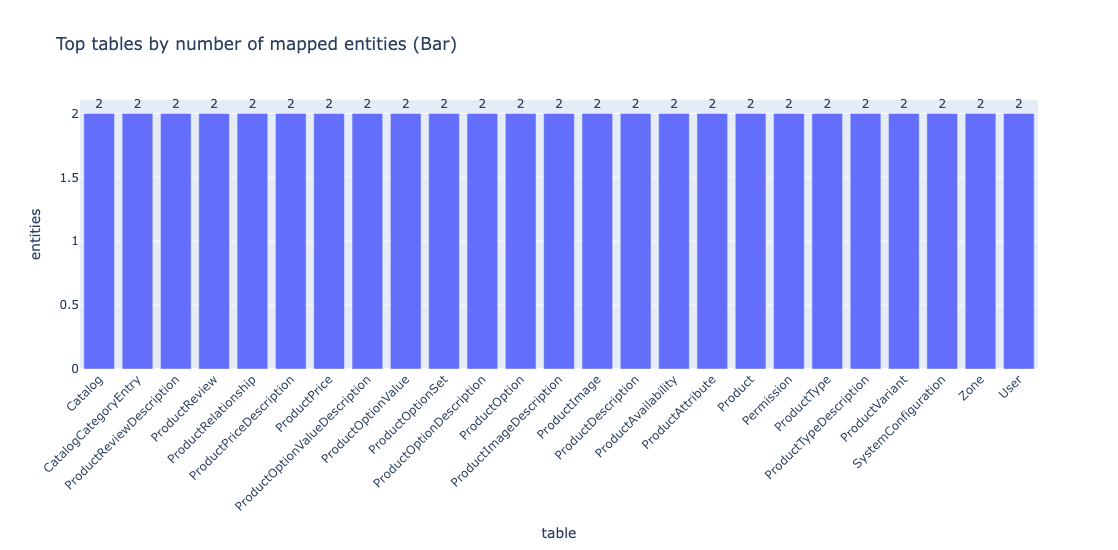

In [2]:
path = os.path.join(DB_DIR, "Jpa_Entities.csv")
df_ent = read_csv_safe(path)
display(df_ent.head(10))

if not df_ent.empty:
    c_entity = find_col(df_ent, "Entity", contains="entity", default="Entity")
    c_table  = find_col(df_ent, "TableName", contains="table", default=None)

    if c_table is None:
        print("[info] No TableName column found — skipping treemap and bar.")
    else:
        tmp = pd.DataFrame({
            "entity":  df_ent[c_entity].astype(str),
            "table":   labelize_na(df_ent[c_table]),
            "value":   1
        })
        # Treemap: each rectangle is a table sized by number of mapped entities
        treemap = tmp.groupby("table")["value"].sum().reset_index(name="entities")
        fig = px.treemap(treemap, path=["table"], values="entities",
                         title="Tables by number of mapped entities (Treemap)")
        fig.update_layout(width=1000, height=600)
        fig.show()

        # Top tables bar
        top_tabs = treemap.sort_values("entities", ascending=False).head(MAX_BARS)
        fig2 = px.bar(top_tabs, x="table", y="entities", text="entities",
                      title="Top tables by number of mapped entities (Bar)")
        fig2.update_traces(textposition="outside", cliponaxis=False)
        fig2.update_layout(xaxis_tickangle=-45, width=1100, height=550)
        fig2.show()
else:
    print("[info] Jpa_Entities.csv missing or empty.")


## 2) Field Annotations — Global Top + Stacked per Entity

,Entity,Field,Type,Annotations,ColumnNames,Source Cypher File: Custom_Queries/Database/Entity_Fields.cypher
0,com.salesmanager.core.model.catalog.catalog.Ca...,auditSection,com.salesmanager.core.model.common.audit.Audit...,NaN,NaN,NaN
1,com.salesmanager.core.model.catalog.catalog.Ca...,code,java.lang.String code,Column,NaN,NaN
2,com.salesmanager.core.model.catalog.catalog.Ca...,defaultCatalog,boolean defaultCatalog,Column,NaN,NaN
3,com.salesmanager.core.model.catalog.catalog.Ca...,entry,java.util.Set entry,OneToMany,NaN,NaN
4,com.salesmanager.core.model.catalog.catalog.Ca...,id,java.lang.Long id,"GeneratedValue,Id",NaN,NaN
5,com.salesmanager.core.model.catalog.catalog.Ca...,merchantStore,com.salesmanager.core.model.merchant.MerchantS...,"JoinColumn,ManyToOne",NaN,NaN
6,com.salesmanager.core.model.catalog.catalog.Ca...,serialVersionUID,long serialVersionUID,NaN,NaN,NaN
7,com.salesmanager.core.model.catalog.catalog.Ca...,sortOrder,java.lang.Integer sortOrder,Column,NaN,NaN
8,com.salesmanager.core.model.catalog.catalog.Ca...,visible,boolean visible,Column,NaN,NaN
9,com.salesmanager.core.model.catalog.catalog.Ca...,auditSection,com.salesmanager.core.model.common.audit.Audit...,NaN,NaN,NaN


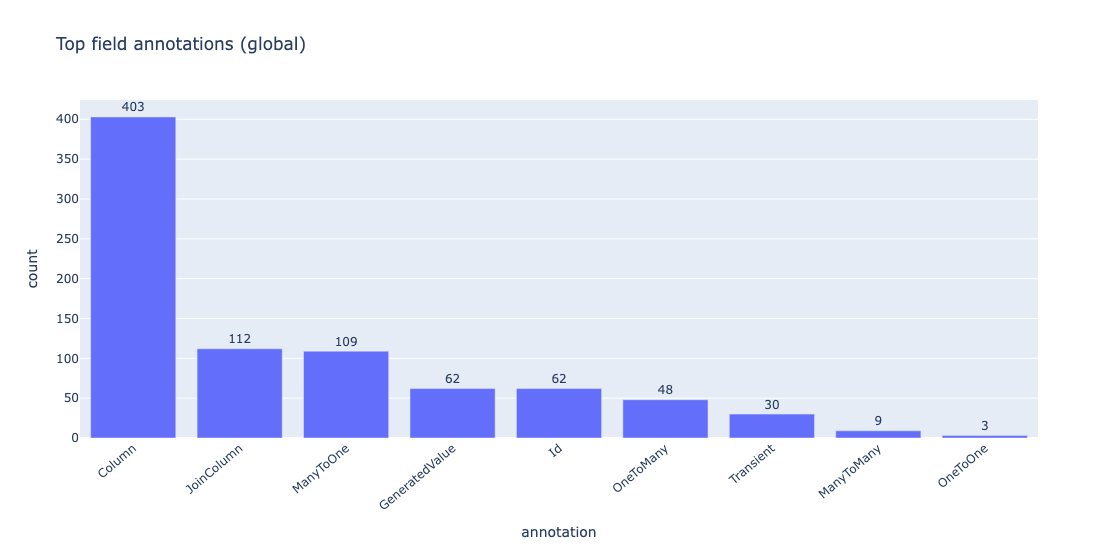

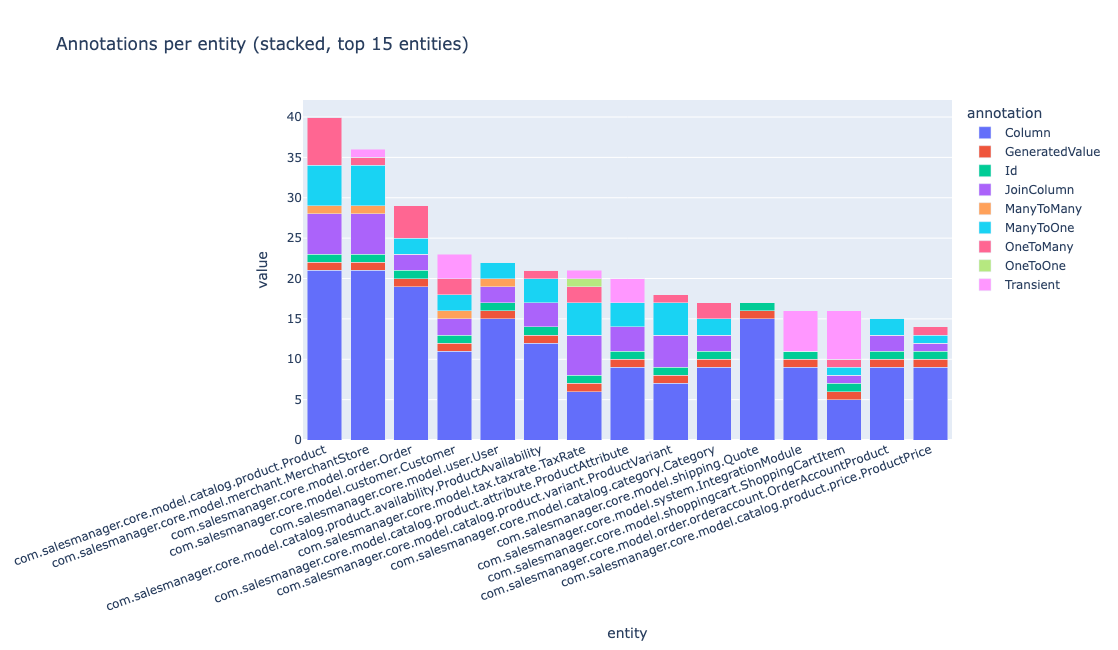

In [3]:
path = os.path.join(DB_DIR, "Entity_Fields.csv")
df_fields = read_csv_safe(path)
display(df_fields.head(10))

if not df_fields.empty:
    c_entity = find_col(df_fields, "Entity", contains="entity", default="Entity")
    c_ann    = find_col(df_fields, "Annotations", contains="annotation", default=None)

    if c_ann is None:
        print("[info] No annotation-like column found — skipping annotation charts.")
    else:
        rows = []
        for _, r in df_fields.iterrows():
            ent = str(r.get(c_entity, ""))
            for ann in parse_listlike(r.get(c_ann)):
                rows.append({"entity": ent, "annotation": ann})
        ann_df = pd.DataFrame(rows)

        if ann_df.empty:
            print("[info] No annotation entries parsed — skipping charts.")
        else:
            # Global top annotations
            top_ann = (ann_df.groupby("annotation").size()
                       .reset_index(name="count")
                       .sort_values("count", ascending=False)
                       .head(MAX_BARS))
            fig = px.bar(top_ann, x="annotation", y="count", text="count",
                         title="Top field annotations (global)")
            fig.update_traces(textposition="outside", cliponaxis=False)
            fig.update_layout(xaxis_tickangle=-40, width=1100, height=550)
            fig.show()

            # Stacked bars per entity (Top entities by total annotations)
            ent_rank = (ann_df.groupby("entity").size()
                        .sort_values(ascending=False)
                        .head(15)).index
            sub = ann_df[ann_df["entity"].isin(ent_rank)]
            pivot = (sub.groupby(["entity","annotation"]).size()
                      .reset_index(name="count")
                      .pivot(index="entity", columns="annotation", values="count")
                      .fillna(0))
            pivot = pivot.loc[ent_rank]  # keep order
            fig2 = px.bar(pivot,
                          title="Annotations per entity (stacked, top 15 entities)",
                          barmode="stack")
            fig2.update_layout(width=1200, height=650, xaxis_tickangle=-20)
            fig2.show()
else:
    print("[info] Entity_Fields.csv missing or empty.")


## 3) Relationship Stats (from DB_Schema)

,Entity,Fields,Relationships,Source Cypher File: Custom_Queries/Database/DB_Schema.cypher
0,com.salesmanager.core.model.catalog.catalog.Ca...,"serialVersionUID,code,auditSection,entry,defau...",2,NaN
1,com.salesmanager.core.model.catalog.catalog.Ca...,"visible,catalog,auditSection,serialVersionUID,...",2,NaN
2,com.salesmanager.core.model.catalog.category.C...,"descriptions,featured,serialVersionUID,sortOrd...",4,NaN
3,com.salesmanager.core.model.catalog.category.C...,"metatagTitle,metatagKeywords,metatagDescriptio...",1,NaN
4,com.salesmanager.core.model.catalog.product.Pr...,"dateAvailable,productHeight,productVirtual,pro...",12,NaN
5,com.salesmanager.core.model.catalog.product.at...,"productOptionSortOrder,productAttributeWeight,...",3,NaN
6,com.salesmanager.core.model.catalog.product.at...,"merchantStore,readOnly,descriptions,productOpt...",2,NaN
7,com.salesmanager.core.model.catalog.product.at...,"productOption,productOptionComment,serialVersi...",1,NaN
8,com.salesmanager.core.model.catalog.product.at...,"serialVersionUID,id,optionDisplayOnly,option,p...",4,NaN
9,com.salesmanager.core.model.catalog.product.at...,"merchantStore,serialVersionUID,productOptionVa...",2,NaN


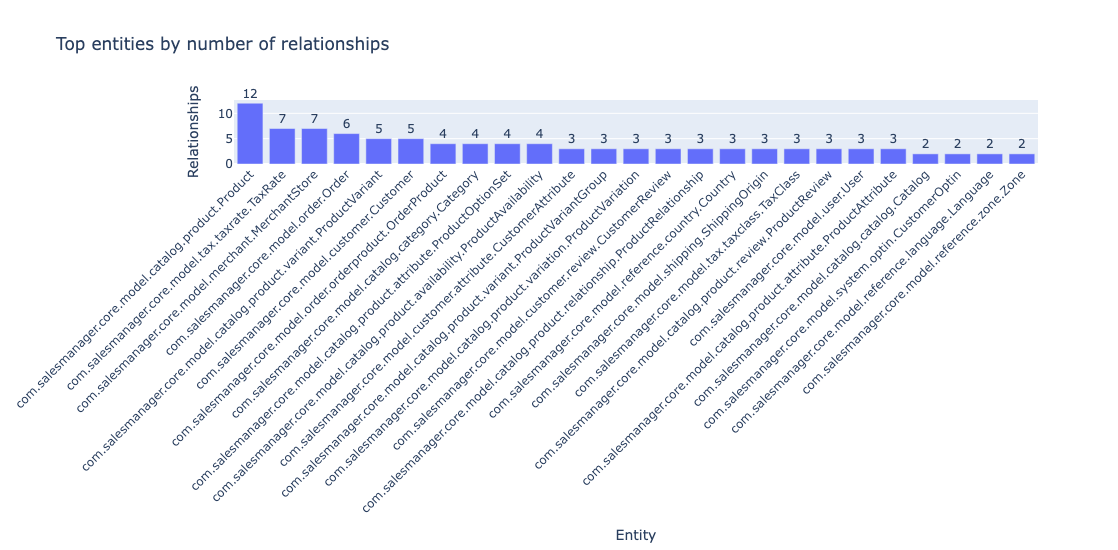

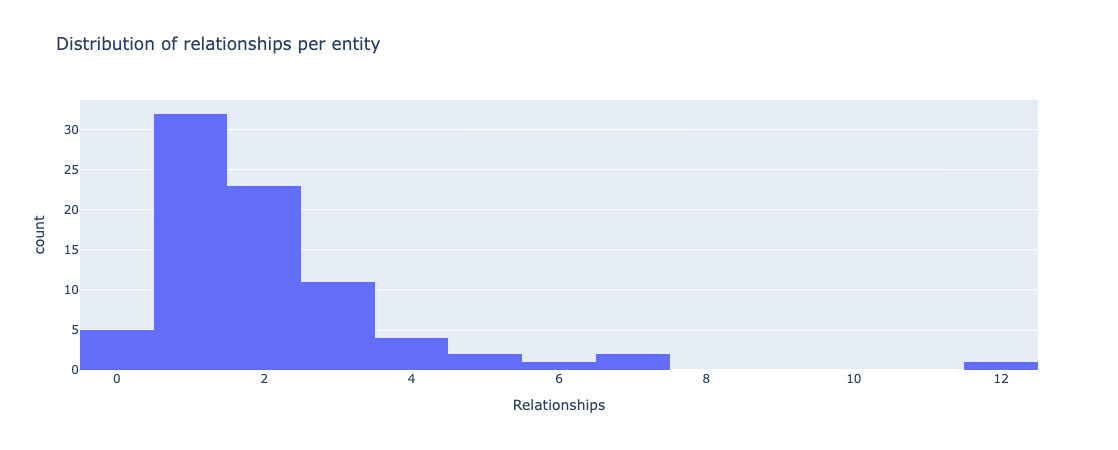

In [4]:
path = os.path.join(DB_DIR, "DB_Schema.csv")
df_schema = read_csv_safe(path)
display(df_schema.head(10))

if not df_schema.empty:
    c_entity = find_col(df_schema, "Entity", contains="entity", default="Entity")
    c_rel    = find_col(df_schema, "Relationships", contains="relationship", default=None)

    if c_rel is None:
        print("[info] No 'Relationships' column found — skipping stats.")
    else:
        rel_series = pd.to_numeric(df_schema[c_rel], errors="coerce").fillna(0)
        df_rel = pd.DataFrame({
            "Entity": df_schema[c_entity].astype(str),
            "Relationships": rel_series.astype(int)
        })

        # Top entities by relationships
        top_rel = df_rel.sort_values("Relationships", ascending=False).head(MAX_BARS)
        fig = px.bar(top_rel, x="Entity", y="Relationships", text="Relationships",
                     title="Top entities by number of relationships")
        fig.update_traces(textposition="outside", cliponaxis=False)
        fig.update_layout(xaxis_tickangle=-45, width=1200, height=550)
        fig.show()

        # Distribution (histogram)
        fig2 = px.histogram(df_rel, x="Relationships", nbins=20,
                            title="Distribution of relationships per entity")
        fig2.update_layout(width=900, height=450)
        fig2.show()
else:
    print("[info] DB_Schema.csv missing or empty.")


## 4) Entity → Entity (by relation) — Sankey (optional)

In [5]:
path = os.path.join(DB_DIR, "Entity_Relationship_Edges.csv")
df_edges = read_csv_safe(path)
display(df_edges.head(10))

# Treat header-only as empty
if not df_edges.empty and len(df_edges.dropna(how="all")) > 0 and len(df_edges.columns) >= 3:
    cols = {c.lower(): c for c in df_edges.columns}
    c_from = cols.get("fromentity") or "fromEntity"
    c_to   = cols.get("toentity") or "toEntity"
    c_rel  = cols.get("relation") or "relation"

    e2e = df_edges.dropna(subset=[c_from, c_to])
    if e2e.empty:
        print("[info] Edges CSV has only empty rows — skipping Sankey.")
    else:
        g = e2e.groupby([c_from, c_to, c_rel]).size().reset_index(name="count")
        # Cap nodes by degree to keep legible
        deg = pd.concat([g.groupby(c_from)["count"].sum(), g.groupby(c_to)["count"].sum()], axis=1).fillna(0).sum(axis=1)
        keep = set(deg.nlargest(80).index)  # allow plenty; Sankey can handle a bit more
        g_c = g[g[c_from].isin(keep) & g[c_to].isin(keep)] if not deg.empty else g

        ents = sorted(set(g_c[c_from].astype(str)).union(set(g_c[c_to].astype(str))))
        if not ents:
            print("[info] No edges after capping — skipping Sankey.")
        else:
            idx = {name: i for i, name in enumerate(ents)}
            src = [idx[s] for s in g_c[c_from].astype(str)]
            tgt = [idx[t] for t in g_c[c_to].astype(str)]
            val = g_c["count"].tolist()
            link_label = g_c[c_rel].astype(str).tolist()

            fig = go.Figure(data=[go.Sankey(
                arrangement="snap",
                node=dict(label=ents, pad=20, thickness=16),
                link=dict(source=src, target=tgt, value=val, label=link_label))])
            fig.update_layout(title_text="Entity → Entity by relation (field-based references)",
                              width=1200, height=700)
            fig.show()
else:
    print("[info] Entity_Relationship_Edges.csv missing or empty — nothing to plot.")


,fromEntity,toEntity,relation,Source Cypher File: Custom_Queries/Database/Entity_Relationship_Edges.cypher
0,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.at...,ManyToOne,NaN
1,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.at...,ManyToOne,NaN
2,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.at...,ManyToOne,NaN
3,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.at...,ManyToOne,NaN
4,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.Pr...,ManyToOne,NaN
5,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.Pr...,ManyToOne,NaN
6,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.Pr...,ManyToOne,NaN
7,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.Pr...,ManyToOne,NaN
8,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.at...,ManyToOne,NaN
9,com.salesmanager.core.model.catalog.product.at...,com.salesmanager.core.model.catalog.product.at...,ManyToOne,NaN
